In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import time
import os
import pickle

In [2]:
def get_labels(file_path):
    '''
    file_path: string 
    '''
    controls = file_path.split("_")[3] #eg. 'T102R009PV680COF'
    regulator = int(controls[5]) + int(controls[7]) / 10
    phase = int(controls[10:13]) / 10
    capacitor = 0
    if controls[14:16] == 'ON':
        capacitor = 1
    return [regulator, phase, capacitor]

In [3]:
def sequencify(df, filename):
    '''
    takes in raw dataframe
    get control settings
    each row is a 2D array:
    [ [x_t], [x_{t+1}] ]
    [y (ie. control settings) ]
    '''
    data_x = []
    data_y = []
    labels = get_labels(filename)
    for i in range(1, len(df)):
        data_x.append([df.iloc[i-1,1:].values,
                       df.iloc[i,1:].values])
        data_y.append(labels)
    
    return np.stack(data_x), np.array(data_y)

In [4]:
def train(model, x_train, y_train, x_dev, y_dev, callbacks, lr=0.01, loss='mse'):
    # x_train can be either an array (1 input), or a list of arrays (multiple inputs)
    model.compile(tf.keras.optimizers.Adam(learning_rate=lr),
             loss=loss, metrics=['accuracy', tf.keras.losses.MeanAbsolutePercentageError()])
    start_time = time.time()
    hist = model.fit(x_train, y_train,
         validation_data=(x_dev, y_dev),
         epochs=1000,
         callbacks=callbacks)
    end_time = time.time()
    training_time = end_time - start_time
    print("Training Time (s):", training_time)
    return hist, training_time

def evaluate(model, x_test, y_test):
    # x_train can be either an array (1 input), or a list of arrays (multiple inputs)
    start_time = time.time()
    evaluation_info = model.evaluate(x_test, y_test)
    loss, acc, mape = evaluation_info[-3], evaluation_info[-2], evaluation_info[-1]
    end_time = time.time()
    eval_time = end_time - start_time
    print("Evaluation Time (s):", eval_time)
    return loss, acc, mape, eval_time

def train_eval(model, x_train, y_train, x_dev, y_dev, x_test, y_test, callbacks, lr=0.01, loss='mse'):
    hist, train_time = train(model, x_train, y_train, x_dev, y_dev, callbacks)
    loss, acc, mape, eval_time = evaluate(model, x_test, y_test)
    return (loss, acc, mape, train_time, eval_time, hist, model.name)

def lr_scheduler(epoch, lr):
    if epoch < 20:
        return lr
    else:
        return lr * (1 - 20 / epoch)

In [5]:
os.listdir('./Data/Training2')

['DS_STRAINING_000-002_T100R095PV300COF.CSV',
 'DS_STRAINING_000-002_T100R100PV000COF.CSV',
 'DS_STRAINING_000-002_T100R100PV300CON.CSV',
 'DS_STRAINING_000-002_T100R090PV300CON.CSV',
 'DS_STRAINING_000-002_T100R100PV000CON.CSV',
 'DS_STRAINING_000-002_T100R095PV000CON.CSV',
 'DS_STRAINING_000-002_T100R090PV000COF.CSV',
 'DS_STRAINING_000-002_T100R100PV600COF.CSV',
 'DS_STRAINING_000-002_T100R095PV640COF.CSV',
 'DS_STRAINING_000-002_T100R090PV000CON.CSV',
 'DS_STRAINING_000-002_T100R090PV600CON.CSV',
 'DS_STRAINING_000-002_T100R090PV300COF.CSV',
 'DS_STRAINING_000-002_T100R090PV640COF.CSV',
 'DS_STRAINING_000-002_T100R105PV640COF.CSV',
 'DS_STRAINING_000-002_T100R095PV600COF.CSV',
 'DS_STRAINING_000-002_T100R095PV640CON.CSV',
 'DS_STRAINING_000-002_T100R095PV300CON.CSV',
 'DS_STRAINING_000-002_T100R095PV000COF.CSV',
 'DS_STRAINING_000-002_T100R100PV680COF.CSV',
 'DS_STRAINING_000-002_T100R100PV300COF.CSV',
 'DS_STRAINING_000-002_T100R105PV640CON.CSV',
 'DS_STRAINING_000-002_T100R090PV6

In [6]:
file_names = os.listdir('./Data/Training2')[:]

# Data Pre-Processing

In [7]:
data_all_x = []
data_all_y = []
for file_path in file_names:
    df = pd.read_csv(f"./Data/Training2/{file_path}", skiprows=[0,1,2,4])
    print(file_path)
    print('num of cols:', len(df.columns))
    print(df.columns)
    if len(df.columns) == 25:
        x, y = sequencify(df, file_path)
        data_all_x.append(x)
        data_all_y.append(y)
    else:
        print("\n *** wonky data. data not added. *** \n")

DS_STRAINING_000-002_T100R095PV300COF.CSV
num of cols: 25
Index(['Time', ' VoltageAtFEEDER1_PhaseAN', ' VoltageAtFEEDER1_PhaseBN',
       ' VoltageAtDBD7_PhaseAN', ' VoltageAtRJ601R_PhaseAN',
       ' VoltageAtFEEDER1_PhaseCN', ' VoltageAtRJ601R_PhaseBN',
       ' VoltageAtRJ601R_PhaseCN', ' VoltageAtDBD7_PhaseBN',
       ' VoltageAtDBD7_PhaseCN', ' CurrentDCircuit1.2Miles_DBD7_PhaseA',
       ' CurrentDCircuit1.2Miles_DBD7_PhaseB',
       ' CurrentDCircuit1.2Miles_DBD7_PhaseC',
       ' CurrentDCircuit1.5Miles_R-J601R_PhaseA',
       ' CurrentDCircuit1.5Miles_R-J601R_PhaseB',
       ' CurrentDCircuit1.5Miles_R-J601R_PhaseC', ' HARMAtFEEDER1_PhaseAN',
       ' HARMAtFEEDER1_PhaseBN', ' HARMAtDBD7_PhaseAN',
       ' HARMAtRJ601R_PhaseAN', ' HARMAtFEEDER1_PhaseCN',
       ' HARMAtRJ601R_PhaseBN', ' HARMAtRJ601R_PhaseCN', ' HARMAtDBD7_PhaseBN',
       ' HARMAtDBD7_PhaseCN'],
      dtype='object')
DS_STRAINING_000-002_T100R100PV000COF.CSV
num of cols: 25
Index(['Time', ' VoltageAtFEEDER1_P

In [8]:
len(data_all_x)

26

In [9]:
x_array = np.concatenate(data_all_x, axis=0)

In [10]:
x_array.shape

(103974, 2, 24)

In [11]:
y_array = np.concatenate(data_all_y, axis=0)

In [12]:
y_array.shape

(103974, 3)

In [13]:
x_training, x_testing, y_training, y_testing = train_test_split(x_array, y_array, test_size=0.2, random_state=200)

In [14]:
print(x_training.shape)
print(x_testing.shape)
print(y_training.shape)
print(y_testing.shape)

(83179, 2, 24)
(20795, 2, 24)
(83179, 3)
(20795, 3)


In [15]:
x_training[0]

array([[-5.390766e+03, -5.713347e+03, -5.963313e+03, -5.948917e+03,
         1.110996e+04, -4.819625e+03,  1.075959e+04, -4.594202e+03,
         1.054024e+04,  1.822168e+02, -2.086692e+01, -1.623628e+02,
         3.116807e+02, -2.944392e+00, -3.096731e+02,  7.856156e+03,
         7.855564e+03,  7.551424e+03,  7.675316e+03,  7.856716e+03,
         7.676443e+03,  7.621030e+03,  7.551189e+03,  7.472249e+03],
       [-3.473031e+03, -7.398684e+03, -4.190045e+03, -4.135881e+03,
         1.087668e+04, -6.554160e+03,  1.067729e+04, -6.314828e+03,
         1.048446e+04,  1.630582e+02,  1.780207e+01, -1.812144e+02,
         2.720949e+02,  6.559251e+01, -3.378030e+02,  7.856157e+03,
         7.855563e+03,  7.551426e+03,  7.675315e+03,  7.856716e+03,
         7.676443e+03,  7.621031e+03,  7.551188e+03,  7.472250e+03]])

In [16]:
scaler_x = RobustScaler()
scaler_y = RobustScaler()

In [17]:
x_training_array_scaled = scaler_x.fit_transform(
    x_training.reshape(-1, x_training.shape[-1])).reshape(x_training.shape)

In [18]:
x_training.shape

(83179, 2, 24)

In [19]:
# we will use the scaled y values for input into the model, not for the labels
scaler_y.fit(y_training)

RobustScaler()

In [20]:
x_train, x_dev, y_train, y_dev = train_test_split(x_training_array_scaled, y_training, test_size=0.2, random_state=200)

In [21]:
y_train_scaled = scaler_y.transform(y_train)
y_dev_scaled = scaler_y.transform(y_dev)

In [22]:
x_test = scaler_x.transform(x_testing.reshape(-1, x_testing.shape[-1])).reshape(x_testing.shape)
y_test_scaled = scaler_y.transform(y_testing)

In [23]:
x_train[0]

array([[ 0.4125024 , -0.68502043,  0.37834982,  0.38462129,  0.28696229,
        -0.70114313,  0.32605328, -0.69547524,  0.33191858,  0.30813803,
         0.61587936, -0.92913482,  0.1035509 ,  0.65921372, -0.75975176,
        -1.15234439, -1.16391292,  0.02856075,  0.17286306, -1.16681853,
         0.12669007,  0.1080614 ,  0.00308419,  0.00183637],
       [ 0.51198912, -0.65903074,  0.48484299,  0.49094652,  0.16045945,
        -0.68338113,  0.20108961, -0.67944461,  0.2085364 ,  0.13561681,
         0.73611331, -0.87579392, -0.05177545,  0.73960682, -0.68379262,
        -1.15234439, -1.16391292,  0.02855901,  0.17286085, -1.16688603,
         0.12669189,  0.1080614 ,  0.00308737,  0.00183637]])

In [24]:
x_train[0].shape

(2, 24)

In [25]:
x_train_dense = x_train.reshape(-1, x_train.shape[1] * x_train.shape[2])

In [26]:
x_dev_dense = x_dev.reshape(-1, x_dev.shape[1] * x_dev.shape[2])
x_test_dense = x_test.reshape(-1, x_test.shape[1] * x_test.shape[2])

In [27]:
x_train_dense[0]

array([ 0.4125024 , -0.68502043,  0.37834982,  0.38462129,  0.28696229,
       -0.70114313,  0.32605328, -0.69547524,  0.33191858,  0.30813803,
        0.61587936, -0.92913482,  0.1035509 ,  0.65921372, -0.75975176,
       -1.15234439, -1.16391292,  0.02856075,  0.17286306, -1.16681853,
        0.12669007,  0.1080614 ,  0.00308419,  0.00183637,  0.51198912,
       -0.65903074,  0.48484299,  0.49094652,  0.16045945, -0.68338113,
        0.20108961, -0.67944461,  0.2085364 ,  0.13561681,  0.73611331,
       -0.87579392, -0.05177545,  0.73960682, -0.68379262, -1.15234439,
       -1.16391292,  0.02855901,  0.17286085, -1.16688603,  0.12669189,
        0.1080614 ,  0.00308737,  0.00183637])

In [28]:
x_train_dense.shape

(66543, 48)

In [29]:
x_dev_dense.shape

(16636, 48)

In [30]:
x_test_dense.shape

(20795, 48)

In [31]:
x_train.shape

(66543, 2, 24)

In [32]:
y_train

array([[ 1. , 68. ,  0. ],
       [ 0.5, 30. ,  0. ],
       [ 1. , 30. ,  1. ],
       ...,
       [ 1. , 60. ,  1. ],
       [ 0.5, 30. ,  0. ],
       [ 1. , 30. ,  0. ]])

In [33]:
y_train_scaled

array([[ 0.5       ,  0.23529412, -1.        ],
       [ 0.        , -0.88235294, -1.        ],
       [ 0.5       , -0.88235294,  0.        ],
       ...,
       [ 0.5       ,  0.        ,  0.        ],
       [ 0.        , -0.88235294, -1.        ],
       [ 0.5       , -0.88235294, -1.        ]])

In [34]:
y_train[0]

array([ 1., 68.,  0.])

In [35]:
input_dim = x_train.shape[1:]

In [36]:
output_dim = y_train.shape[-1]

In [37]:
input_dim

(2, 24)

In [38]:
output_dim

3

# Model Building

A: Attention Models

B: Models without Attention, Input has both States and Controls

C: Models without Attention, Input has only States


In [39]:
num_features = 30

Category A Multiheaded Attention Models

In [40]:
# Attention Model
# Category A: LSTM with Multiheaded Attention

multiheaded_input1 = tf.keras.Input(shape=(input_dim))
controls_inputm = tf.keras.Input(shape=(output_dim,))

multi_attn_layer1 = tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=3)(multiheaded_input1, multiheaded_input1)
mattn_lstm1 = tf.keras.layers.LSTM(num_features,
                                   activation='tanh')(multi_attn_layer1)

dense_controlsm = tf.keras.layers.Dense(10, activation='tanh')(controls_inputm)

concatm = tf.keras.layers.Concatenate()([dense_controlsm, mattn_lstm1])

attn_dense1m = tf.keras.layers.Dense(25, activation='tanh')(concatm)
attn_dense2m = tf.keras.layers.Dense(10, activation='tanh')(attn_dense1m)
attn_dense3m = tf.keras.layers.Dense(output_dim, activation='relu')(attn_dense2m)

model_attn_lstm_m = tf.keras.Model(inputs=[multiheaded_input1, controls_inputm],
                              outputs=attn_dense3m, name='MultiAttention_LSTM')

model_attn_lstm_m.summary()

Model: "MultiAttention_LSTM"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2, 24)]      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
multi_head_attention (MultiHead (None, 2, 24)        1212        input_1[0][0]                    
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 10)           40          input_2[0][0]  

In [41]:
# Attention Model
# Category A: LSTM with Multiheaded Attention 2

multiheaded_input_1_query = tf.keras.Input(shape=(input_dim))
multiheaded_input_1_value = tf.keras.Input(shape=(input_dim))
controls_input_m = tf.keras.Input(shape=(output_dim,))

multi_attn_layer_1 = tf.keras.layers.MultiHeadAttention(num_heads=4,
                                                        key_dim=3)(multiheaded_input_1_query, multiheaded_input_1_value)
mattn_lstm_1 = tf.keras.layers.LSTM(num_features,
                                   activation='tanh')(multi_attn_layer_1)

dense_controls_m = tf.keras.layers.Dense(10, activation='tanh')(controls_input_m)

concat_m = tf.keras.layers.Concatenate()([dense_controls_m, mattn_lstm_1])

attn_dense1_m = tf.keras.layers.Dense(25, activation='tanh')(concat_m)
attn_dense2_m = tf.keras.layers.Dense(10, activation='tanh')(attn_dense1_m)
attn_dense3_m = tf.keras.layers.Dense(output_dim, activation='relu')(attn_dense2_m)

model_attn_lstm_multiheaded = tf.keras.Model(inputs=[multiheaded_input_1_query, multiheaded_input_1_value, controls_input_m],
                              outputs=attn_dense3_m, name='MultiheadedAttention_LSTM')

model_attn_lstm_multiheaded.summary()

Model: "MultiheadedAttention_LSTM"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 2, 24)]      0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 2, 24)]      0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
multi_head_attention_1 (MultiHe (None, 2, 24)        1212        input_3[0][0]                    
                                                                 input_4[0

In [42]:
# Attention Model
# Category A: LSTM with Multiheaded Attention Simple

multiheaded_input_1_query_simple = tf.keras.Input(shape=(input_dim))
multiheaded_input_1_value_simple = tf.keras.Input(shape=(input_dim))
controls_input_m_simple = tf.keras.Input(shape=(output_dim,))

multi_attn_layer_1_simple = tf.keras.layers.MultiHeadAttention(num_heads=4,
                                                        key_dim=3)(multiheaded_input_1_query_simple,
                                                                   multiheaded_input_1_value_simple)
mattn_lstm_1_simple = tf.keras.layers.LSTM(num_features,
                                   activation='tanh')(multi_attn_layer_1_simple)

# dense_controls_m = tf.keras.layers.Dense(10, activation='tanh')(controls_input_m)

concat_m_simple = tf.keras.layers.Concatenate()([controls_input_m_simple, mattn_lstm_1_simple])

attn_dense1_m_simple = tf.keras.layers.Dense(15, activation='tanh')(concat_m_simple)
# attn_dense2_m = tf.keras.layers.Dense(15, activation='tanh')(attn_dense1_m)
attn_dense2_m_simple = tf.keras.layers.Dense(output_dim, activation='relu')(attn_dense1_m_simple)

model_attn_lstm_multiheaded_simple = tf.keras.Model(
    inputs=[multiheaded_input_1_query_simple, multiheaded_input_1_value_simple, controls_input_m_simple],
                              outputs=attn_dense2_m_simple, name='MultiheadedAttention_LSTM_Simple')

model_attn_lstm_multiheaded_simple.summary()

Model: "MultiheadedAttention_LSTM_Simple"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 2, 24)]      0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 2, 24)]      0                                            
__________________________________________________________________________________________________
multi_head_attention_2 (MultiHe (None, 2, 24)        1212        input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 3)]          0             

In [43]:
# Attention Model 
# Cat A: Multiheaded Dense

query_input_multiheaded_dense = tf.keras.Input(shape=(input_dim))
value_input_multiheaded_dense = tf.keras.Input(shape=(input_dim))

controls_input_multiheaded_dense = tf.keras.Input(shape=(output_dim,))

attn1_multiheaded_dense = tf.keras.layers.Attention()([query_input_multiheaded_dense, value_input_multiheaded_dense])

flatten1_multiheaded_dense = tf.keras.layers.Flatten()(attn1_multiheaded_dense)

flatten_dense1_multiheaded_dense = tf.keras.layers.Dense(num_features, 
                               activation='tanh')(flatten1_multiheaded_dense)

dense_controls_multiheaded_dense = tf.keras.layers.Dense(10, activation='tanh')(controls_input_multiheaded_dense)

concat_multiheaded_dense = tf.keras.layers.Concatenate()([dense_controls_multiheaded_dense, flatten_dense1_multiheaded_dense])

attn_dense1_multiheaded_dense = tf.keras.layers.Dense(25, activation='tanh')(concat_multiheaded_dense)
attn_dense2_multiheaded_dense = tf.keras.layers.Dense(10, activation='tanh')(attn_dense1_multiheaded_dense)
attn_dense3_multiheaded_dense = tf.keras.layers.Dense(output_dim, activation='relu')(attn_dense2_multiheaded_dense)

model_multiheaded_dense = tf.keras.Model(inputs=[query_input_multiheaded_dense, value_input_multiheaded_dense, controls_input_multiheaded_dense],
                                         outputs=attn_dense3_multiheaded_dense, name='MultiAttention_Dense')

model_multiheaded_dense.summary()

Model: "MultiAttention_Dense"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 2, 24)]      0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 2, 24)]      0                                            
__________________________________________________________________________________________________
attention (Attention)           (None, 2, 24)        0           input_9[0][0]                    
                                                                 input_10[0][0]                   
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 3)]          0                         

In [44]:
# Attention Model 3
# Category A: Multiheaded BiDirectional LSTM

query_inputc2_m = tf.keras.Input(shape=(input_dim))
value_inputc2_m = tf.keras.Input(shape=(input_dim))

controls_input2_m = tf.keras.Input(shape=(output_dim,))

attn1c2_m = tf.keras.layers.Attention()([query_inputc2_m, value_inputc2_m])

attn_lstm1c2_m = tf.keras.layers.LSTM(num_features, 
                               activation='tanh')
attn_bi1c2_m = tf.keras.layers.Bidirectional(attn_lstm1c2_m)(attn1c2_m)

dense_controls2_m = tf.keras.layers.Dense(10, activation='tanh')(controls_input2_m)

concat2_m = tf.keras.layers.Concatenate()([dense_controls2_m, attn_bi1c2_m])

attn_dense1c2_m = tf.keras.layers.Dense(25, activation='tanh')(concat2_m)
attn_dense2c2_m = tf.keras.layers.Dense(10, activation='tanh')(attn_dense1c2_m)
attn_dense3c2_m = tf.keras.layers.Dense(output_dim, activation='relu')(attn_dense2c2_m)

model_attn_c2_m = tf.keras.Model(inputs=[query_inputc2_m, value_inputc2_m, controls_input2_m],
                               outputs=attn_dense3c2_m, name='MultiAttention_BiLSTM')

model_attn_c2_m.summary()

Model: "MultiAttention_BiLSTM"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 2, 24)]      0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 2, 24)]      0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 3)]          0                                            
__________________________________________________________________________________________________
attention_1 (Attention)         (None, 2, 24)        0           input_12[0][0]                   
                                                                 input_13[0][0

Category A Self-Attention Models

In [45]:
# Attention Model
# Category A: LSTM

query_inputd = tf.keras.Input(shape=(input_dim))
value_inputd = tf.keras.Input(shape=(input_dim))

controls_inputd = tf.keras.Input(shape=(output_dim,))

attn1d = tf.keras.layers.Attention()([query_inputd, value_inputd])

attn_lstm1d = tf.keras.layers.LSTM(num_features, 
                               activation='tanh')(attn1d)

dense_controlsd = tf.keras.layers.Dense(10, activation='tanh')(controls_inputd)

concatd = tf.keras.layers.Concatenate()([dense_controlsd, attn_lstm1d])

attn_dense1d = tf.keras.layers.Dense(25, activation='tanh')(concatd)
attn_dense2d = tf.keras.layers.Dense(10, activation='tanh')(attn_dense1d)
attn_dense3d = tf.keras.layers.Dense(output_dim, activation='relu')(attn_dense2d)

model_attn_d = tf.keras.Model(inputs=[query_inputd, value_inputd, controls_inputd],
                              outputs=attn_dense3d, name='Attention_LSTM')

model_attn_d.summary()

Model: "Attention_LSTM"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 2, 24)]      0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           [(None, 2, 24)]      0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           [(None, 3)]          0                                            
__________________________________________________________________________________________________
attention_2 (Attention)         (None, 2, 24)        0           input_15[0][0]                   
                                                                 input_16[0][0]      

In [46]:
# Attention Model 3
# Category A: BiDirectional LSTM

query_inputc2 = tf.keras.Input(shape=(input_dim))
value_inputc2 = tf.keras.Input(shape=(input_dim))

controls_input2 = tf.keras.Input(shape=(output_dim,))

attn1c2 = tf.keras.layers.Attention()([query_inputc2, value_inputc2])

attn_lstm1c2 = tf.keras.layers.LSTM(num_features, 
                               activation='tanh')
attn_bi1c2 = tf.keras.layers.Bidirectional(attn_lstm1c2)(attn1c2)

dense_controls2 = tf.keras.layers.Dense(10, activation='tanh')(controls_input2)

concat2 = tf.keras.layers.Concatenate()([dense_controls2, attn_bi1c2])

attn_dense1c2 = tf.keras.layers.Dense(25, activation='tanh')(concat2)
attn_dense2c2 = tf.keras.layers.Dense(10, activation='tanh')(attn_dense1c2)
attn_dense3c2 = tf.keras.layers.Dense(output_dim, activation='relu')(attn_dense2c2)

model_attn_c2 = tf.keras.Model(inputs=[query_inputc2, value_inputc2, controls_input2],
                               outputs=attn_dense3c2, name='Attention_BiLSTM')

model_attn_c2.summary()

Model: "Attention_BiLSTM"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 2, 24)]      0                                            
__________________________________________________________________________________________________
input_19 (InputLayer)           [(None, 2, 24)]      0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           [(None, 3)]          0                                            
__________________________________________________________________________________________________
attention_3 (Attention)         (None, 2, 24)        0           input_18[0][0]                   
                                                                 input_19[0][0]    

In [47]:
# Attention Model 
# Cat A: Dense

query_inpute = tf.keras.Input(shape=(input_dim))
value_inpute = tf.keras.Input(shape=(input_dim))

controls_inpute = tf.keras.Input(shape=(output_dim,))

attn1e = tf.keras.layers.Attention()([query_inpute, value_inpute])

flatten1e = tf.keras.layers.Flatten()(attn1e)

flatten_dense1e = tf.keras.layers.Dense(num_features, 
                               activation='tanh')(flatten1e)

dense_controlse = tf.keras.layers.Dense(10, activation='tanh')(controls_inpute)

concate = tf.keras.layers.Concatenate()([dense_controlse, flatten_dense1e])

attn_dense1e = tf.keras.layers.Dense(25, activation='tanh')(concate)
attn_dense2e = tf.keras.layers.Dense(10, activation='tanh')(attn_dense1e)
attn_dense3e = tf.keras.layers.Dense(output_dim, activation='relu')(attn_dense2e)

model_attn_e = tf.keras.Model(inputs=[query_inpute, value_inpute, controls_inpute], outputs=attn_dense3e, name='Attention_Dense')

model_attn_e.summary()

Model: "Attention_Dense"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 2, 24)]      0                                            
__________________________________________________________________________________________________
input_22 (InputLayer)           [(None, 2, 24)]      0                                            
__________________________________________________________________________________________________
attention_4 (Attention)         (None, 2, 24)        0           input_21[0][0]                   
                                                                 input_22[0][0]                   
__________________________________________________________________________________________________
input_23 (InputLayer)           [(None, 3)]          0                              

Category B Models

In [48]:
# Category B: LSTM with Controls
input_layer_lstm = tf.keras.Input(shape=(input_dim))

control_input_lstm = tf.keras.Input(shape=(output_dim,))

layer_1_lstm_controls = tf.keras.layers.LSTM(25, 
                               activation='tanh')(input_layer_lstm)

dense_controls_lstm = tf.keras.layers.Dense(10, activation='tanh')(control_input_lstm)

concat_lstm = tf.keras.layers.Concatenate()([dense_controls_lstm, layer_1_lstm_controls])

lstm_dense1 = tf.keras.layers.Dense(25, activation='tanh')(concat_lstm)
lstm_dense2 = tf.keras.layers.Dense(10, activation='tanh')(lstm_dense1)
lstm_dense3 = tf.keras.layers.Dense(output_dim, activation='relu')(lstm_dense2)

output_lstm_controls = tf.keras.layers.Dense(output_dim, activation='relu')(lstm_dense3)


model_lstm_controls = tf.keras.Model(inputs=[input_layer_lstm, control_input_lstm],
                                     outputs=output_lstm_controls, name='LSTM_controls')

model_lstm_controls.summary()

Model: "LSTM_controls"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 3)]          0                                            
__________________________________________________________________________________________________
input_24 (InputLayer)           [(None, 2, 24)]      0                                            
__________________________________________________________________________________________________
dense_32 (Dense)                (None, 10)           40          input_25[0][0]                   
__________________________________________________________________________________________________
lstm_6 (LSTM)                   (None, 25)           5000        input_24[0][0]                   
______________________________________________________________________________________

In [49]:
# Category B: BiLSTM with Controls
input_layer_bilstm = tf.keras.Input(shape=(input_dim))

control_input_bilstm = tf.keras.Input(shape=(output_dim,))

layer_1_bilstm_controls = tf.keras.layers.LSTM(25, 
                               activation='tanh')
bi_1_controls = tf.keras.layers.Bidirectional(layer_1_bilstm_controls)(input_layer_bilstm)

dense_controls_bilstm = tf.keras.layers.Dense(10, activation='tanh')(control_input_bilstm)

concat_bilstm = tf.keras.layers.Concatenate()([dense_controls_bilstm, bi_1_controls])

bilstm_dense1 = tf.keras.layers.Dense(25, activation='tanh')(concat_bilstm)
bilstm_dense2 = tf.keras.layers.Dense(10, activation='tanh')(bilstm_dense1)
bilstm_dense3 = tf.keras.layers.Dense(output_dim, activation='relu')(bilstm_dense2)

output_bilstm_controls = tf.keras.layers.Dense(output_dim, activation='relu')(bilstm_dense3)


model_bilstm_controls = tf.keras.Model(inputs=[input_layer_bilstm, control_input_bilstm],
                                     outputs=output_bilstm_controls, name='BiLSTM_controls')

model_bilstm_controls.summary()

Model: "BiLSTM_controls"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           [(None, 3)]          0                                            
__________________________________________________________________________________________________
input_26 (InputLayer)           [(None, 2, 24)]      0                                            
__________________________________________________________________________________________________
dense_37 (Dense)                (None, 10)           40          input_27[0][0]                   
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 50)           10000       input_26[0][0]                   
____________________________________________________________________________________

In [50]:
# Category B: Dense Encoding
input_layer_dense = tf.keras.Input(shape=(input_dim[0] * input_dim[1]))

controls_input_dense = tf.keras.Input(shape=(output_dim,))

concat_dense = tf.keras.layers.Concatenate()([input_layer_dense, controls_input_dense])

dense1 = tf.keras.layers.Dense(40, activation='tanh')(concat_dense)
dense2 = tf.keras.layers.Dense(25, activation='tanh')(dense1)
dense3 = tf.keras.layers.Dense(15, activation='tanh')(dense2)
dense4 = tf.keras.layers.Dense(10, activation='tanh')(dense3)

output_dense = tf.keras.layers.Dense(output_dim, activation='relu')(dense4)

model_dense = tf.keras.Model(inputs=[input_layer_dense, controls_input_dense], outputs=output_dense, name='Dense_controls')

model_dense.summary()

Model: "Dense_controls"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           [(None, 48)]         0                                            
__________________________________________________________________________________________________
input_29 (InputLayer)           [(None, 3)]          0                                            
__________________________________________________________________________________________________
concatenate_10 (Concatenate)    (None, 51)           0           input_28[0][0]                   
                                                                 input_29[0][0]                   
__________________________________________________________________________________________________
dense_42 (Dense)                (None, 40)           2080        concatenate_10[0][0]

Category C Models

In [51]:
# Category C: LSTM
input_layer_lstm = tf.keras.Input(shape=(input_dim))

layer_1_lstm = tf.keras.layers.LSTM(25, 
                               return_sequences=True, 
                               activation='tanh')(input_layer_lstm)
layer_2_lstm = tf.keras.layers.LSTM(15, 
                               return_sequences=True, 
                               activation='tanh')(layer_1_lstm)
layer_3_lstm = tf.keras.layers.LSTM(10, 
                               activation='tanh')(layer_2_lstm)
output_lstm = tf.keras.layers.Dense(output_dim, activation='relu')(layer_3_lstm)


model_lstm = tf.keras.Model(inputs=input_layer_lstm, outputs=output_lstm, name='C_LSTM')

model_lstm.summary()

Model: "C_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        [(None, 2, 24)]           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 2, 25)             5000      
_________________________________________________________________
lstm_9 (LSTM)                (None, 2, 15)             2460      
_________________________________________________________________
lstm_10 (LSTM)               (None, 10)                1040      
_________________________________________________________________
dense_47 (Dense)             (None, 3)                 33        
Total params: 8,533
Trainable params: 8,533
Non-trainable params: 0
_________________________________________________________________


In [52]:
# Category C: LSTM 1 Layer
# https://www.sciencedirect.com/science/article/pii/S0306261921001811
# Experiment study of machine-learning-based approximate model predictive control for energy-efficient building control
input_layer_lstm1 = tf.keras.Input(shape=(input_dim))


layer_1_lstm1 = tf.keras.layers.LSTM(20, 
                               activation='tanh')(input_layer_lstm1)

output_lstm1 = tf.keras.layers.Dense(output_dim, activation='relu')(layer_1_lstm1)


model_lstm1 = tf.keras.Model(inputs=input_layer_lstm1, outputs=output_lstm1, name='C_LSTM1Layer')

model_lstm1.summary()

Model: "C_LSTM1Layer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        [(None, 2, 24)]           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 20)                3600      
_________________________________________________________________
dense_48 (Dense)             (None, 3)                 63        
Total params: 3,663
Trainable params: 3,663
Non-trainable params: 0
_________________________________________________________________


In [53]:
# BiLSTM
input_layer_bi = tf.keras.Input(shape=(input_dim))

layer_1_bi = tf.keras.layers.LSTM(25, 
                               return_sequences=True, 
                               activation='tanh')
bi_1 = tf.keras.layers.Bidirectional(layer_1_bi)(input_layer_bi)

layer_2_bi = tf.keras.layers.LSTM(15, 
                               return_sequences=True, 
                               activation='tanh')
bi_2 = tf.keras.layers.Bidirectional(layer_2_bi)(bi_1)

layer_3_bi = tf.keras.layers.LSTM(10, 
                               activation='tanh')
bi_3 = tf.keras.layers.Bidirectional(layer_3_bi)(bi_2)

output_bi = tf.keras.layers.Dense(output_dim, activation='relu')(bi_3)


model_bi = tf.keras.Model(inputs=input_layer_bi, outputs=output_bi, name='C_BiLSTM')

model_bi.summary()

Model: "C_BiLSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        [(None, 2, 24)]           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 2, 50)             10000     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 2, 30)             7920      
_________________________________________________________________
bidirectional_5 (Bidirection (None, 20)                3280      
_________________________________________________________________
dense_49 (Dense)             (None, 3)                 63        
Total params: 21,263
Trainable params: 21,263
Non-trainable params: 0
_________________________________________________________________


In [54]:
# Category C: Dense Encoding without Controls
input_layer_dense_seq = tf.keras.Input(shape=(input_dim[0] * input_dim[1]))

dense1_seq = tf.keras.layers.Dense(40, activation='tanh')(input_layer_dense_seq)
dense2_seq = tf.keras.layers.Dense(25, activation='tanh')(dense1_seq)
dense3_seq = tf.keras.layers.Dense(15, activation='tanh')(dense2_seq)
dense4_seq = tf.keras.layers.Dense(10, activation='tanh')(dense3_seq)

output_dense_seq = tf.keras.layers.Dense(output_dim, activation='relu')(dense4_seq)

model_dense_seq = tf.keras.Model(inputs=input_layer_dense_seq, outputs=output_dense_seq, name="C_Dense")

model_dense_seq.summary()

Model: "C_Dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        [(None, 48)]              0         
_________________________________________________________________
dense_50 (Dense)             (None, 40)                1960      
_________________________________________________________________
dense_51 (Dense)             (None, 25)                1025      
_________________________________________________________________
dense_52 (Dense)             (None, 15)                390       
_________________________________________________________________
dense_53 (Dense)             (None, 10)                160       
_________________________________________________________________
dense_54 (Dense)             (None, 3)                 33        
Total params: 3,568
Trainable params: 3,568
Non-trainable params: 0
_________________________________________________________

# Model Training

In [55]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=20,
    restore_best_weights=True,
)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

In [56]:
callbacks = [early_stopping_callback, lr_scheduler]

In [57]:
model_data = []

In [58]:
lstm_data = train_eval(model_lstm, x_train, y_train, x_dev, y_dev, x_test, y_testing, callbacks)
model_data.append(lstm_data)

Epoch 1/1000
2080/2080 [==============================] - 18s 6ms/step - loss: 183.0909 - accuracy: 0.8275 - mean_absolute_percentage_error: 1806321280.0000 - val_loss: 81.9865 - val_accuracy: 0.8407 - val_mean_absolute_percentage_error: 1487315712.0000
Epoch 2/1000
2080/2080 [==============================] - 12s 6ms/step - loss: 64.2073 - accuracy: 0.8411 - mean_absolute_percentage_error: 1204984960.0000 - val_loss: 52.8972 - val_accuracy: 0.8439 - val_mean_absolute_percentage_error: 1112426880.0000
Epoch 3/1000
2080/2080 [==============================] - 12s 6ms/step - loss: 48.0368 - accuracy: 0.8425 - mean_absolute_percentage_error: 887826752.0000 - val_loss: 52.8221 - val_accuracy: 0.8439 - val_mean_absolute_percentage_error: 800516992.0000
Epoch 4/1000
2080/2080 [==============================] - 12s 6ms/step - loss: 42.2286 - accuracy: 0.8434 - mean_absolute_percentage_error: 763702784.0000 - val_loss: 37.3161 - val_accuracy: 0.8449 - val_mean_absolute_percentage_error: 712406

In [59]:
lstm_controls_data = train_eval(model_lstm_controls, 
                         [x_train, y_train_scaled], y_train,
                         [x_dev, y_dev_scaled], y_dev,
                         [x_test, y_test_scaled], y_testing, callbacks)
model_data.append(lstm_controls_data)

Epoch 1/1000
2080/2080 [==============================] - 10s 4ms/step - loss: 62.4675 - accuracy: 0.8913 - mean_absolute_percentage_error: 681399296.0000 - val_loss: 0.1641 - val_accuracy: 0.9606 - val_mean_absolute_percentage_error: 120394984.0000
Epoch 2/1000
2080/2080 [==============================] - 8s 4ms/step - loss: 0.1659 - accuracy: 0.9610 - mean_absolute_percentage_error: 104087600.0000 - val_loss: 0.1631 - val_accuracy: 0.9627 - val_mean_absolute_percentage_error: 88797848.0000
Epoch 3/1000
2080/2080 [==============================] - 8s 4ms/step - loss: 0.2394 - accuracy: 0.9448 - mean_absolute_percentage_error: 109823928.0000 - val_loss: 0.1651 - val_accuracy: 0.8473 - val_mean_absolute_percentage_error: 153102768.0000
Epoch 4/1000
2080/2080 [==============================] - 8s 4ms/step - loss: 0.1532 - accuracy: 0.9077 - mean_absolute_percentage_error: 134070856.0000 - val_loss: 0.1649 - val_accuracy: 0.8976 - val_mean_absolute_percentage_error: 115654688.0000
Epoch 5

In [60]:
lstm1layer_data = train_eval(model_lstm1, x_train, y_train, x_dev, y_dev, x_test, y_testing, callbacks)
model_data.append(lstm1layer_data)

Epoch 1/1000
2080/2080 [==============================] - 9s 4ms/step - loss: 131.8320 - accuracy: 0.8400 - mean_absolute_percentage_error: 1593749248.0000 - val_loss: 59.6460 - val_accuracy: 0.8680 - val_mean_absolute_percentage_error: 1136979456.0000
Epoch 2/1000
2080/2080 [==============================] - 7s 3ms/step - loss: 47.4980 - accuracy: 0.8709 - mean_absolute_percentage_error: 858717632.0000 - val_loss: 42.2646 - val_accuracy: 0.8604 - val_mean_absolute_percentage_error: 756600384.0000
Epoch 3/1000
2080/2080 [==============================] - 7s 4ms/step - loss: 36.9975 - accuracy: 0.8782 - mean_absolute_percentage_error: 610252608.0000 - val_loss: 36.2931 - val_accuracy: 0.8831 - val_mean_absolute_percentage_error: 522700800.0000
Epoch 4/1000
2080/2080 [==============================] - 7s 4ms/step - loss: 31.7912 - accuracy: 0.8889 - mean_absolute_percentage_error: 531281184.0000 - val_loss: 24.9892 - val_accuracy: 0.8976 - val_mean_absolute_percentage_error: 548819968.00

In [61]:
bilstm_data = train_eval(model_bi, x_train, y_train, x_dev, y_dev, x_test, y_testing, callbacks)
model_data.append(bilstm_data)

Epoch 1/1000
2080/2080 [==============================] - 32s 12ms/step - loss: 159.9319 - accuracy: 0.8278 - mean_absolute_percentage_error: 1897297664.0000 - val_loss: 82.5141 - val_accuracy: 0.8388 - val_mean_absolute_percentage_error: 1567883520.0000
Epoch 2/1000
2080/2080 [==============================] - 22s 11ms/step - loss: 52.2013 - accuracy: 0.8534 - mean_absolute_percentage_error: 934176256.0000 - val_loss: 39.1543 - val_accuracy: 0.8789 - val_mean_absolute_percentage_error: 587778112.0000
Epoch 3/1000
2080/2080 [==============================] - 22s 11ms/step - loss: 42.2202 - accuracy: 0.8703 - mean_absolute_percentage_error: 710866112.0000 - val_loss: 37.0815 - val_accuracy: 0.8780 - val_mean_absolute_percentage_error: 567552192.0000
Epoch 4/1000
2080/2080 [==============================] - 22s 11ms/step - loss: 41.9575 - accuracy: 0.8753 - mean_absolute_percentage_error: 720991872.0000 - val_loss: 36.0377 - val_accuracy: 0.8761 - val_mean_absolute_percentage_error: 5509

In [62]:
bilstm_controls_data = train_eval(model_bilstm_controls, 
                         [x_train, y_train_scaled], y_train,
                         [x_dev, y_dev_scaled], y_dev,
                         [x_test, y_test_scaled], y_testing, callbacks)
model_data.append(bilstm_controls_data)

Epoch 1/1000
2080/2080 [==============================] - 15s 6ms/step - loss: 28.4746 - accuracy: 0.8443 - mean_absolute_percentage_error: 189674128.0000 - val_loss: 0.3699 - val_accuracy: 0.9349 - val_mean_absolute_percentage_error: 509320.6562
Epoch 2/1000
2080/2080 [==============================] - 11s 6ms/step - loss: 0.3230 - accuracy: 0.9413 - mean_absolute_percentage_error: 468321.7812 - val_loss: 0.3174 - val_accuracy: 0.9612 - val_mean_absolute_percentage_error: 102279.5469
Epoch 3/1000
2080/2080 [==============================] - 12s 6ms/step - loss: 0.4972 - accuracy: 0.9233 - mean_absolute_percentage_error: 6202932.0000 - val_loss: 0.3164 - val_accuracy: 0.9603 - val_mean_absolute_percentage_error: 182135.8281
Epoch 4/1000
2080/2080 [==============================] - 11s 6ms/step - loss: 0.3236 - accuracy: 0.9515 - mean_absolute_percentage_error: 427843.2812 - val_loss: 0.3150 - val_accuracy: 0.9582 - val_mean_absolute_percentage_error: 226281.9688
Epoch 5/1000
2080/2080 

In [63]:
attn_c2_data = train_eval(model_attn_c2,
                         [x_train, x_train, y_train_scaled], y_train,
                         [x_dev, x_dev, y_dev_scaled], y_dev,
                         [x_test, x_test, y_test_scaled], y_testing, callbacks)
model_data.append(attn_c2_data)

Epoch 1/1000
2080/2080 [==============================] - 15s 6ms/step - loss: 105.8527 - accuracy: 0.8505 - mean_absolute_percentage_error: 732736448.0000 - val_loss: 0.4897 - val_accuracy: 0.9437 - val_mean_absolute_percentage_error: 130052392.0000
Epoch 2/1000
2080/2080 [==============================] - 11s 5ms/step - loss: 0.2167 - accuracy: 0.9591 - mean_absolute_percentage_error: 117843440.0000 - val_loss: 0.1312 - val_accuracy: 0.9610 - val_mean_absolute_percentage_error: 107722544.0000
Epoch 3/1000
2080/2080 [==============================] - 11s 5ms/step - loss: 0.1322 - accuracy: 0.9675 - mean_absolute_percentage_error: 107403616.0000 - val_loss: 0.1259 - val_accuracy: 0.9799 - val_mean_absolute_percentage_error: 111850520.0000
Epoch 4/1000
2080/2080 [==============================] - 11s 5ms/step - loss: 0.1258 - accuracy: 0.9723 - mean_absolute_percentage_error: 106267456.0000 - val_loss: 0.1144 - val_accuracy: 0.9760 - val_mean_absolute_percentage_error: 111456384.0000
Ep

In [64]:
attn_c2_m_data = train_eval(model_attn_c2_m,
                         [x_train, x_train, y_train_scaled], y_train,
                         [x_dev, x_dev, y_dev_scaled], y_dev,
                         [x_test, x_test, y_test_scaled], y_testing, callbacks)
model_data.append(attn_c2_m_data)

Epoch 1/1000
2080/2080 [==============================] - 15s 6ms/step - loss: 107.1227 - accuracy: 0.8809 - mean_absolute_percentage_error: 738651648.0000 - val_loss: 1.5977 - val_accuracy: 0.9569 - val_mean_absolute_percentage_error: 47662968.0000
Epoch 2/1000
2080/2080 [==============================] - 11s 5ms/step - loss: 0.4209 - accuracy: 0.9710 - mean_absolute_percentage_error: 24087180.0000 - val_loss: 0.1517 - val_accuracy: 0.9822 - val_mean_absolute_percentage_error: 5499277.5000
Epoch 3/1000
2080/2080 [==============================] - 11s 5ms/step - loss: 0.1394 - accuracy: 0.9819 - mean_absolute_percentage_error: 2259600.2500 - val_loss: 0.1307 - val_accuracy: 0.9782 - val_mean_absolute_percentage_error: 512284.7500
Epoch 4/1000
2080/2080 [==============================] - 11s 5ms/step - loss: 0.1361 - accuracy: 0.9847 - mean_absolute_percentage_error: 1708680.2500 - val_loss: 0.1428 - val_accuracy: 0.9637 - val_mean_absolute_percentage_error: 5914052.5000
Epoch 5/1000
20

In [65]:
attn_d_data = train_eval(model_attn_d,
                         [x_train, x_train, y_train_scaled], y_train,
                         [x_dev, x_dev, y_dev_scaled], y_dev,
                         [x_test, x_test, y_test_scaled], y_testing, callbacks)
model_data.append(attn_d_data)

Epoch 1/1000
2080/2080 [==============================] - 10s 4ms/step - loss: 83.3543 - accuracy: 0.8869 - mean_absolute_percentage_error: 337805472.0000 - val_loss: 0.5393 - val_accuracy: 0.9322 - val_mean_absolute_percentage_error: 79086432.0000
Epoch 2/1000
2080/2080 [==============================] - 8s 4ms/step - loss: 0.1993 - accuracy: 0.9474 - mean_absolute_percentage_error: 53814580.0000 - val_loss: 0.1350 - val_accuracy: 0.9009 - val_mean_absolute_percentage_error: 33506426.0000
Epoch 3/1000
2080/2080 [==============================] - 8s 4ms/step - loss: 0.1132 - accuracy: 0.9573 - mean_absolute_percentage_error: 26466094.0000 - val_loss: 0.0926 - val_accuracy: 0.9626 - val_mean_absolute_percentage_error: 12272979.0000
Epoch 4/1000
2080/2080 [==============================] - 8s 4ms/step - loss: 0.0961 - accuracy: 0.9607 - mean_absolute_percentage_error: 9634373.0000 - val_loss: 0.0867 - val_accuracy: 0.9630 - val_mean_absolute_percentage_error: 6792147.5000
Epoch 5/1000
20

In [66]:
attn_e_data = train_eval(model_attn_e,
                         [x_train, x_train, y_train_scaled], y_train,
                         [x_dev, x_dev, y_dev_scaled], y_dev,
                         [x_test, x_test, y_test_scaled], y_testing, callbacks)
model_data.append(attn_e_data)

Epoch 1/1000
2080/2080 [==============================] - 6s 3ms/step - loss: 80.9507 - accuracy: 0.9101 - mean_absolute_percentage_error: 423031872.0000 - val_loss: 0.5770 - val_accuracy: 0.9659 - val_mean_absolute_percentage_error: 90776768.0000
Epoch 2/1000
2080/2080 [==============================] - 6s 3ms/step - loss: 0.3946 - accuracy: 0.9187 - mean_absolute_percentage_error: 99368320.0000 - val_loss: 0.1101 - val_accuracy: 0.9136 - val_mean_absolute_percentage_error: 94122392.0000
Epoch 3/1000
2080/2080 [==============================] - 6s 3ms/step - loss: 0.0974 - accuracy: 0.9578 - mean_absolute_percentage_error: 75802824.0000 - val_loss: 0.0608 - val_accuracy: 0.9785 - val_mean_absolute_percentage_error: 43368964.0000
Epoch 4/1000
2080/2080 [==============================] - 6s 3ms/step - loss: 0.0620 - accuracy: 0.9771 - mean_absolute_percentage_error: 33586908.0000 - val_loss: 0.0317 - val_accuracy: 0.9726 - val_mean_absolute_percentage_error: 18500924.0000
Epoch 5/1000
2

In [67]:
dense_data = train_eval(model_dense,
                         [x_train_dense, y_train_scaled], y_train,
                         [x_dev_dense, y_dev_scaled], y_dev,
                         [x_test_dense, y_test_scaled], y_testing, callbacks)
model_data.append(dense_data)

Epoch 1/1000
2080/2080 [==============================] - 6s 3ms/step - loss: 91.0484 - accuracy: 0.8847 - mean_absolute_percentage_error: 510602240.0000 - val_loss: 5.5340 - val_accuracy: 0.9455 - val_mean_absolute_percentage_error: 166865808.0000
Epoch 2/1000
2080/2080 [==============================] - 5s 3ms/step - loss: 6.6287 - accuracy: 0.9340 - mean_absolute_percentage_error: 172960560.0000 - val_loss: 4.9322 - val_accuracy: 0.9287 - val_mean_absolute_percentage_error: 173741264.0000
Epoch 3/1000
2080/2080 [==============================] - 6s 3ms/step - loss: 5.2231 - accuracy: 0.8956 - mean_absolute_percentage_error: 168952096.0000 - val_loss: 4.5236 - val_accuracy: 0.8680 - val_mean_absolute_percentage_error: 173058928.0000
Epoch 4/1000
2080/2080 [==============================] - 6s 3ms/step - loss: 4.4307 - accuracy: 0.9131 - mean_absolute_percentage_error: 158701776.0000 - val_loss: 3.7380 - val_accuracy: 0.9124 - val_mean_absolute_percentage_error: 168315392.0000
Epoch 5

In [68]:
dense_data_seq = train_eval(model_dense_seq,
                         x_train_dense, y_train,
                         x_dev_dense, y_dev,
                         x_test_dense, y_testing, callbacks)
model_data.append(dense_data_seq)

Epoch 1/1000
2080/2080 [==============================] - 6s 3ms/step - loss: 261.1610 - accuracy: 0.7470 - mean_absolute_percentage_error: 2611506944.0000 - val_loss: 149.1257 - val_accuracy: 0.7700 - val_mean_absolute_percentage_error: 2279601920.0000
Epoch 2/1000
2080/2080 [==============================] - 5s 3ms/step - loss: 101.8745 - accuracy: 0.8253 - mean_absolute_percentage_error: 1600397824.0000 - val_loss: 75.9563 - val_accuracy: 0.8299 - val_mean_absolute_percentage_error: 1261605632.0000
Epoch 3/1000
2080/2080 [==============================] - 5s 3ms/step - loss: 68.7577 - accuracy: 0.8337 - mean_absolute_percentage_error: 1097068544.0000 - val_loss: 70.5757 - val_accuracy: 0.8313 - val_mean_absolute_percentage_error: 1283341056.0000
Epoch 4/1000
2080/2080 [==============================] - 5s 3ms/step - loss: 63.8783 - accuracy: 0.8343 - mean_absolute_percentage_error: 1028788864.0000 - val_loss: 65.5307 - val_accuracy: 0.8501 - val_mean_absolute_percentage_error: 10343

In [69]:
multiheaded_dense_data = train_eval(model_multiheaded_dense,
                         [x_train, x_train, y_train_scaled], y_train,
                         [x_dev, x_dev, y_dev_scaled], y_dev,
                         [x_test, x_test, y_test_scaled], y_testing, callbacks)
model_data.append(multiheaded_dense_data)

Epoch 1/1000
2080/2080 [==============================] - 6s 3ms/step - loss: 117.6465 - accuracy: 0.8635 - mean_absolute_percentage_error: 934356992.0000 - val_loss: 0.6960 - val_accuracy: 0.9502 - val_mean_absolute_percentage_error: 93227144.0000
Epoch 2/1000
2080/2080 [==============================] - 6s 3ms/step - loss: 0.3330 - accuracy: 0.9647 - mean_absolute_percentage_error: 87126032.0000 - val_loss: 0.2060 - val_accuracy: 0.9519 - val_mean_absolute_percentage_error: 69479696.0000
Epoch 3/1000
2080/2080 [==============================] - 6s 3ms/step - loss: 0.2182 - accuracy: 0.9471 - mean_absolute_percentage_error: 71440328.0000 - val_loss: 0.1707 - val_accuracy: 0.9458 - val_mean_absolute_percentage_error: 76324512.0000
Epoch 4/1000
2080/2080 [==============================] - 6s 3ms/step - loss: 0.1536 - accuracy: 0.9539 - mean_absolute_percentage_error: 60914568.0000 - val_loss: 0.2064 - val_accuracy: 0.9528 - val_mean_absolute_percentage_error: 60373816.0000
Epoch 5/1000


In [70]:
model_attn_lstm_m_data = train_eval(model_attn_lstm_m,
                         [x_train, y_train_scaled], y_train,
                         [x_dev, y_dev_scaled], y_dev,
                         [x_test, y_test_scaled], y_testing, callbacks)
model_data.append(model_attn_lstm_m_data)

Epoch 1/1000
2080/2080 [==============================] - 12s 5ms/step - loss: 103.5440 - accuracy: 0.8749 - mean_absolute_percentage_error: 668934592.0000 - val_loss: 0.5057 - val_accuracy: 0.9228 - val_mean_absolute_percentage_error: 47872164.0000
Epoch 2/1000
2080/2080 [==============================] - 10s 5ms/step - loss: 0.2917 - accuracy: 0.9195 - mean_absolute_percentage_error: 72013440.0000 - val_loss: 0.2696 - val_accuracy: 0.9225 - val_mean_absolute_percentage_error: 101705984.0000
Epoch 3/1000
2080/2080 [==============================] - 10s 5ms/step - loss: 0.2411 - accuracy: 0.9240 - mean_absolute_percentage_error: 81697528.0000 - val_loss: 0.1311 - val_accuracy: 0.9697 - val_mean_absolute_percentage_error: 76951440.0000
Epoch 4/1000
2080/2080 [==============================] - 10s 5ms/step - loss: 0.1689 - accuracy: 0.9607 - mean_absolute_percentage_error: 65152276.0000 - val_loss: 0.1340 - val_accuracy: 0.9609 - val_mean_absolute_percentage_error: 52503100.0000
Epoch 5/

In [71]:
model_attn_lstm_multiheaded_data = train_eval(model_attn_lstm_multiheaded,
                         [x_train, x_train, y_train_scaled], y_train,
                         [x_dev, x_dev, y_dev_scaled], y_dev,
                         [x_test, x_test, y_test_scaled], y_testing, callbacks)
model_data.append(model_attn_lstm_multiheaded_data)

Epoch 1/1000
2080/2080 [==============================] - 12s 5ms/step - loss: 82.5053 - accuracy: 0.8582 - mean_absolute_percentage_error: 343586528.0000 - val_loss: 1.0536 - val_accuracy: 0.9177 - val_mean_absolute_percentage_error: 114651088.0000
Epoch 2/1000
2080/2080 [==============================] - 10s 5ms/step - loss: 0.3654 - accuracy: 0.9549 - mean_absolute_percentage_error: 89504104.0000 - val_loss: 0.1158 - val_accuracy: 0.9589 - val_mean_absolute_percentage_error: 91190304.0000
Epoch 3/1000
2080/2080 [==============================] - 10s 5ms/step - loss: 0.4313 - accuracy: 0.9303 - mean_absolute_percentage_error: 113929168.0000 - val_loss: 0.2196 - val_accuracy: 0.9266 - val_mean_absolute_percentage_error: 129378408.0000
Epoch 4/1000
2080/2080 [==============================] - 10s 5ms/step - loss: 0.1626 - accuracy: 0.9536 - mean_absolute_percentage_error: 111027400.0000 - val_loss: 0.1469 - val_accuracy: 0.9641 - val_mean_absolute_percentage_error: 97149984.0000
Epoch 

In [72]:
model_attn_lstm_multiheaded_simple_data = train_eval(model_attn_lstm_multiheaded_simple,
                         [x_train, x_train, y_train_scaled], y_train,
                         [x_dev, x_dev, y_dev_scaled], y_dev,
                         [x_test, x_test, y_test_scaled], y_testing, callbacks)
model_data.append(model_attn_lstm_multiheaded_simple_data)

Epoch 1/1000
2080/2080 [==============================] - 12s 5ms/step - loss: 76.2735 - accuracy: 0.8926 - mean_absolute_percentage_error: 628288512.0000 - val_loss: 0.2338 - val_accuracy: 0.9574 - val_mean_absolute_percentage_error: 11822874.0000
Epoch 2/1000
2080/2080 [==============================] - 10s 5ms/step - loss: 0.1594 - accuracy: 0.9666 - mean_absolute_percentage_error: 6481296.5000 - val_loss: 0.1734 - val_accuracy: 0.9601 - val_mean_absolute_percentage_error: 7277994.5000
Epoch 3/1000
2080/2080 [==============================] - 10s 5ms/step - loss: 0.1985 - accuracy: 0.9219 - mean_absolute_percentage_error: 5734629.0000 - val_loss: 0.1898 - val_accuracy: 0.9224 - val_mean_absolute_percentage_error: 354202.5938
Epoch 4/1000
2080/2080 [==============================] - 10s 5ms/step - loss: 0.1752 - accuracy: 0.9128 - mean_absolute_percentage_error: 1331261.0000 - val_loss: 0.1855 - val_accuracy: 0.9228 - val_mean_absolute_percentage_error: 15278.6787
Epoch 5/1000
2080/2

# Plot Data

In [73]:
model_data.sort()

In [74]:
model_data

[(0.0004743565514218062,
  1.0,
  1660310.5,
  358.52299761772156,
  1.6200649738311768,
  'MultiheadedAttention_LSTM_Simple'),
 (0.020427411422133446,
  0.9597980380058289,
  4657321.0,
  220.5782492160797,
  1.2069110870361328,
  'Attention_Dense'),
 (0.04643414169549942,
  0.9993748664855957,
  30214500.0,
  343.2024402618408,
  1.7779269218444824,
  'Attention_BiLSTM'),
 (0.07778764516115189,
  0.9233469367027283,
  1129595.0,
  378.03106021881104,
  1.6164531707763672,
  'MultiAttention_LSTM'),
 (0.08511161059141159,
  0.9667227864265442,
  54268716.0,
  168.25590634346008,
  1.1999812126159668,
  'MultiAttention_Dense'),
 (0.08676540851593018,
  0.9607117176055908,
  6747890.5,
  201.1190791130066,
  1.5408689975738525,
  'Attention_LSTM'),
 (0.11981690675020218,
  0.9604231715202332,
  90910640.0,
  222.69195318222046,
  1.6502447128295898,
  'MultiheadedAttention_LSTM'),
 (0.12206438183784485,
  0.9233469367027283,
  45738524.0,
  420.08938479423523,
  1.7878220081329346,
  'Mu

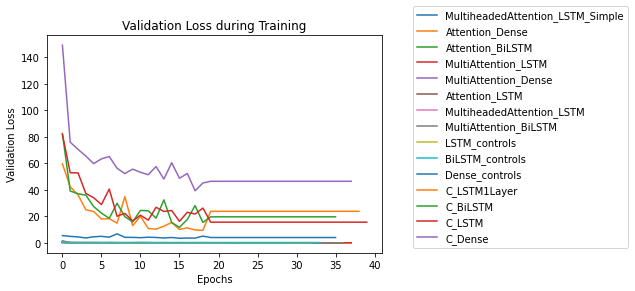

In [75]:
plt.title("Validation Loss during Training")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
for data in model_data:
    # (loss, acc, mape, train_time, eval_time, hist, model.name)
    plt.plot(data[-2].history['val_loss'], label=data[-1])
plt.legend(loc='lower right', bbox_to_anchor=(1.75,0))

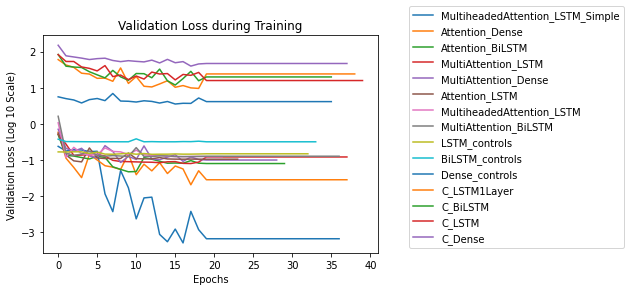

In [76]:
plt.title("Validation Loss during Training")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss (Log 10 Scale)")
for data in model_data:
    # (loss, acc, mape, train_time, eval_time, hist, model.name)
    plt.plot(np.log10(data[-2].history['val_loss']), label=data[-1])
plt.legend(loc='lower right', bbox_to_anchor=(1.75,0))

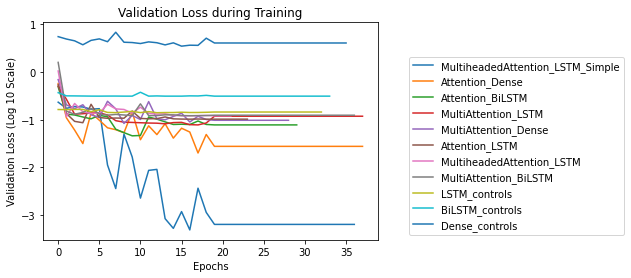

In [77]:
plt.title("Validation Loss during Training")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss (Log 10 Scale)")
for data in model_data:
    # (loss, acc, mape, train_time, eval_time, hist, model.name)
    if data[-1][0] != "C":
        plt.plot(np.log10(data[-2].history['val_loss']), label=data[-1])
plt.legend(loc='lower right', bbox_to_anchor=(1.75,0))

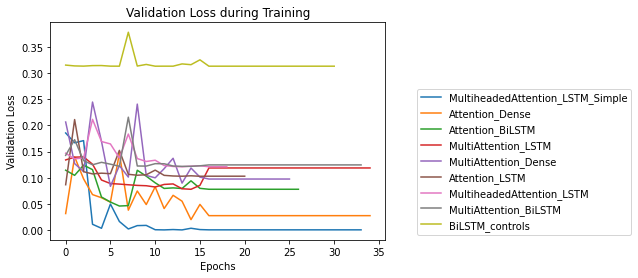

In [78]:
plt.title("Validation Loss during Training")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
for data in model_data:
    # (loss, acc, mape, train_time, eval_time, hist, model.name)
    if data[-1][0] in ["M", "A", "B"]:
        plt.plot(data[-2].history['val_loss'][3:], label=data[-1])
plt.legend(loc='lower right', bbox_to_anchor=(1.75,0))

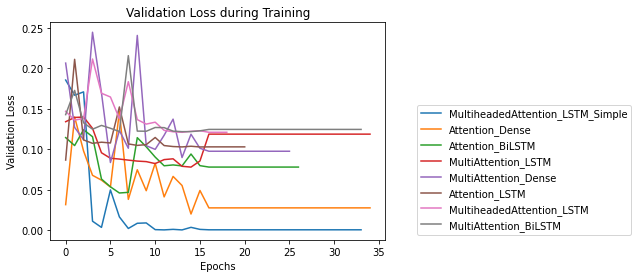

In [79]:
plt.title("Validation Loss during Training")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
for data in model_data:
    # (loss, acc, mape, train_time, eval_time, hist, model.name)
    if data[-1][0] in ["M", "A"]:
        plt.plot(data[-2].history['val_loss'][3:], label=data[-1])
plt.legend(loc='lower right', bbox_to_anchor=(1.75,0))

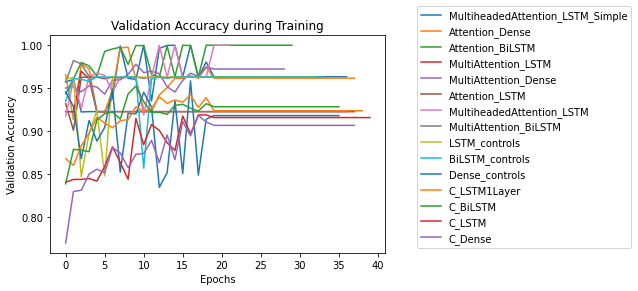

In [80]:
plt.title("Validation Accuracy during Training")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
for data in model_data:
    # (loss, acc, mape, train_time, eval_time, hist, model.name)
    plt.plot(data[-2].history['val_accuracy'], label=data[-1])
plt.legend(loc='lower right', bbox_to_anchor=(1.75,0))

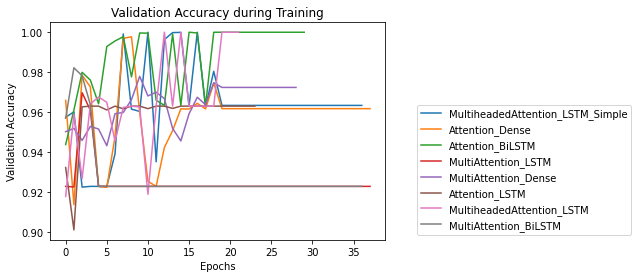

In [81]:
plt.title("Validation Accuracy during Training")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
for data in model_data:
    # (loss, acc, mape, train_time, eval_time, hist, model.name)
    if data[-1][0] in ['A', 'M']:
        plt.plot(data[-2].history['val_accuracy'], label=data[-1])
plt.legend(loc='lower right', bbox_to_anchor=(1.75,0))

In [82]:
# Plot Test Loss
test_losses = {}

# Plot Test Accuracy
test_acc = {}

# (loss, acc, mape, train_time, eval_time, hist, model.name)
for data in model_data:
    test_losses[data[-1]] = data[0]
    test_acc[data[-1]] = data[1]

<ipython-input-83-590da7168d18>:21: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


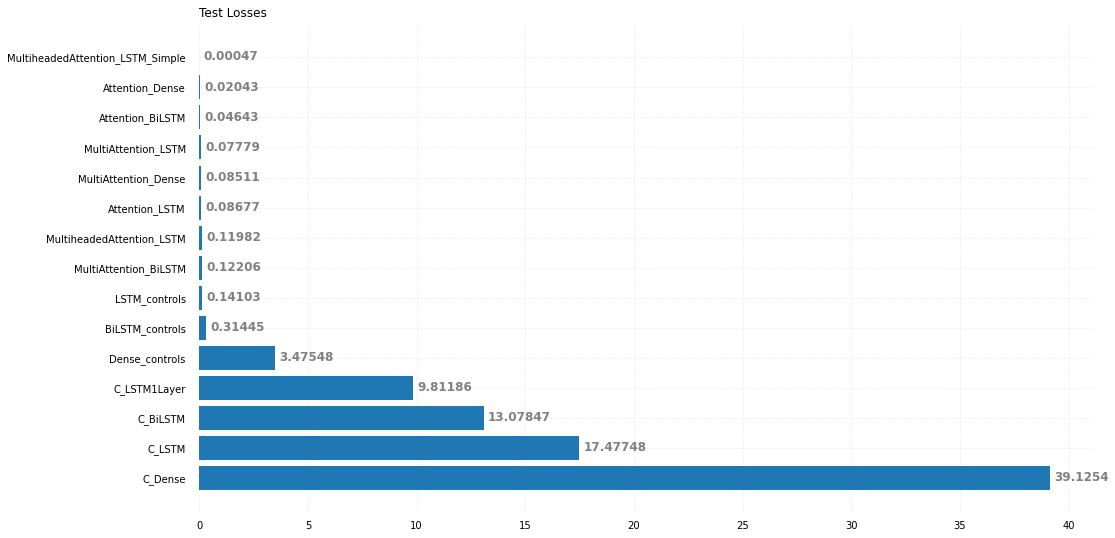

In [83]:
# Figure Size
fig, ax = plt.subplots(figsize =(16, 9))
 
# Horizontal Bar Plot
ax.barh(list(test_losses.keys()),
       list(test_losses.values()))
 
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
 
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
 
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
# Show top values
ax.invert_yaxis()
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 5)),
             fontsize = 12, fontweight ='bold',
             color ='grey')

ax.set_title("Test Losses",
         loc ='left', )
plt.show()

<ipython-input-84-461eaf823cb9>:21: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


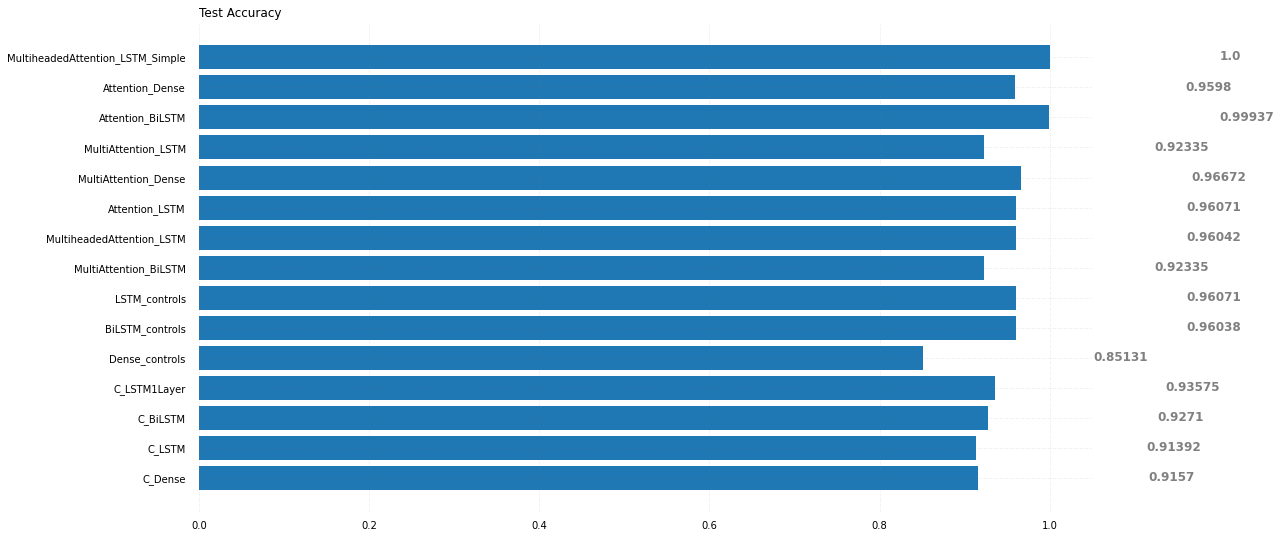

In [84]:
# Figure Size
fig, ax = plt.subplots(figsize =(16, 9))
 
# Horizontal Bar Plot
ax.barh(list(test_acc.keys()),
       list(test_acc.values()))
 
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
 
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
 
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
# Show top values
ax.invert_yaxis()
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 5)),
             fontsize = 12, fontweight ='bold',
             color ='grey')

ax.set_title("Test Accuracy",
         loc ='left', )
plt.show()

# Saving Data

In [86]:
# (loss, acc, mape, train_time, eval_time, hist, model.name)
for data in model_data:
    name = data[-1]
    if name[0] not in ['M', "A", "C"]:
        name = f'B_{name}'
#     elif "Multiheaded_LSTM" in name:
#         name = "Multi_LSTM"
    h = data[-2].history
    with open('Trained_Models2/{}.pkl'.format(name), 'wb') as f:
        # (loss, acc, mape, train_time, eval_time, hist, model.name)
        pickle.dump([data[0], data[1], data[2], data[3], data[4], h, name], f)

In [87]:
model_multiheaded_dense.save('Saved_Models/Training/MultiheadedAttention_Dense.h5')
model_attn_lstm_multiheaded.save('Saved_Models/Training/MultiheadedAttention_LSTM1.h5')
model_attn_lstm_m.save('Saved_Models/Training/MultiheadedAttention_LSTM2.h5')
model_attn_lstm_multiheaded_simple.save('Saved_Models/Training/MultiheadedAttentionLSTM_Simple.h5')
model_attn_c2_m.save('Saved_Models/Training/MultiheadedAttention_BiLSTM.h5')
model_attn_c2.save('Saved_Models/Training/Attention_BiLSTM.h5')
model_attn_d.save('Saved_Models/Training/Attention_LSTM.h5')
model_attn_e.save('Saved_Models/Training/Attention_Dense.h5')
model_lstm_controls.save('Saved_Models/Training/B_LSTM.h5')
model_bilstm_controls.save('Saved_Models/Training/B_BiLSTM.h5')
model_dense.save('Saved_Models/Training/B_Dense.h5')
model_lstm.save('Saved_Models/Training/C_LSTM.h5')
model_lstm1.save('Saved_Models/Training/C_LSTM1Layer.h5')
model_bi.save('Saved_Models/Training/C_BiLSTM.h5')
model_dense_seq.save('Saved_Models/Training/C_Dense.h5')